In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os
import random
os.chdir('../Network-analysis/')
import utilities as util
os.chdir('../src/')

['/Users/francescopiccoli/Desktop/Complex Networks/Final project/higgs-twitter-network-science/src', '/Users/francescopiccoli/opt/anaconda3/envs/higgs-twitter-project-env/lib/python310.zip', '/Users/francescopiccoli/opt/anaconda3/envs/higgs-twitter-project-env/lib/python3.10', '/Users/francescopiccoli/opt/anaconda3/envs/higgs-twitter-project-env/lib/python3.10/lib-dynload', '', '/Users/francescopiccoli/opt/anaconda3/envs/higgs-twitter-project-env/lib/python3.10/site-packages', '../']


In [2]:
friends_file_path = "../output/higgs-friends-lcc.edgelist"
friends_reply_path = "../output/higgs-friends-reply.edgelist"
friends_mention_path = "../output/higgs-friends-mention.edgelist"
friends_retweet_path = "../output/higgs-friends-retweet.edgelist"

In [3]:
attr_names = ["source", "target", "day"]
# Read the edge list file into a graph
G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),))
#print(G_reply.edges(data=True))

subgraph_reply = util.get_subgraph(G_reply, 2000)
subgraph_df = pd.DataFrame(subgraph_reply.edges(data=True), columns=['source', 'target', 'attribute'])
# Extract the 'day' attribute from the 'attribute' column and add it as a separate column
subgraph_df['day'] = [d['day'] for d in subgraph_df['attribute']]
# Drop the 'attribute' column, which is no longer needed
subgraph_df.drop('attribute', axis=1, inplace=True)
subgraph_df.reset_index(drop=True, inplace=True)
print(subgraph_df)

subgraph of: 2000 nodes
     source  target  day
0        88  126681    1
1        88  188556    2
2        88   18921    1
3        88  165626    1
4        88  368454    1
...     ...     ...  ...
1994   3693   14270    1
1995   2055   30832    1
1996   2055  187856    1
1997   2055   94565    1
1998   2055  131318    1

[1999 rows x 3 columns]


['378352', '54881', '25228', '438514', '124356']
{0: [1, 1, 1, 1, 1], 1: [538, 159, 5, 5, 1], 2: [538, 159, 5, 5, 1], 4: [538, 159, 5, 3, 1], 26: [1, 1, 1, 1, 1], 14: [1, 1, 1, 1, 1], 5: [283, 1, 1, 1, 1], 3: [538, 159, 5, 1, 1], 16: [1, 1, 1, 1, 1], 7: [1, 1, 1, 1, 1], 6: [538, 159, 5, 1, 1], 10: [100, 433, 1, 1, 1]}


Text(0, 0.5, 'Avg # infected nodes')

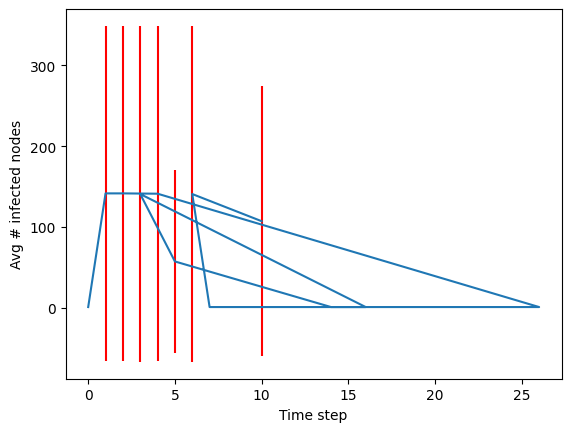

In [9]:
# Simulate temporal spreading
iterations = 5
# time: infected nodes dictionary timestamp:[infected nodes] (value is an array, each array ith element tells the n of infected nodes at the ith iteration)
infected_nodes_time_dict = {0:[1 for _ in range(iterations)]} 
seed_nodes = []
for n in range(iterations):
  # Take a random seed node
  seed_node = random.choice(list(subgraph_reply.nodes()))
  seed_nodes.append(seed_node)
  # Keep a set of the infected nodes
  infected_nodes = {seed_node}

  cur_day = 0
  nodes_infected_in_timestamp = set()

  # Iterate over all the edge list pandas dataframe that is already chronolgically ordered
  for row in subgraph_df.itertuples():
    node1 = row.source
    node2 = row.target
    time = row.day

    if row.day != cur_day:
      # In a nutshell: New timestamp, so update the nodes that were infected in
      # the previous timestep, and create a new set for the nodes that'll be
      # infected in this current timestep
      cur_day = row.day
      infected_nodes.update(nodes_infected_in_timestamp)
      nodes_infected_in_timestamp = set()

    # For each edge, check if one of the two node (either source or destination) is in the infected set
    # If it is, add the other node to the infected set.
    if node1 in infected_nodes and node2 not in infected_nodes:
      nodes_infected_in_timestamp.add(node2)
    if node1 not in infected_nodes and node2 in infected_nodes:
      nodes_infected_in_timestamp.add(node1)

    if time in infected_nodes_time_dict:
      if len(infected_nodes_time_dict[time]) == n+1:
        # It's n-1 because we are updating the last timestep
        infected_nodes_time_dict[time][n-1] = len(infected_nodes) + len(nodes_infected_in_timestamp)
      else:
        infected_nodes_time_dict[time].append(len(infected_nodes) + 
                                        len(nodes_infected_in_timestamp))
    else:
      infected_nodes_time_dict[time] = [len(infected_nodes) + 
                                        len(nodes_infected_in_timestamp)]

print(seed_nodes)
print(infected_nodes_time_dict)

time_list = list(infected_nodes_time_dict.keys())
infected_nodes_time_lists = list(infected_nodes_time_dict.values())

average_infected_list = [np.mean(infected_nodes_list_ith_time) for infected_nodes_list_ith_time in infected_nodes_time_lists]
sd_list = [np.std(infected_nodes_list_ith_time) for infected_nodes_list_ith_time in infected_nodes_time_lists]

plt.errorbar(time_list, average_infected_list, sd_list, ecolor='red')
plt.xlabel('Time step')
plt.ylabel('Avg # infected nodes')